# 3 Data Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap

In [3]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = "../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = "../output/tables/4/"
OUTPUT_FIGURES_PATH = "../output/figures/4/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, "east_df.pkl"))
west_df = pd.read_pickle(os.path.join(DATA_PATH, "west_df.pkl"))

west_complete_days_df = pd.read_pickle(
    os.path.join(DATA_PATH, "west_complete_days_df.pkl")
)
east_complete_days_df = pd.read_pickle(
    os.path.join(DATA_PATH, "east_complete_days_df.pkl")
)

# group on dt to remove trajectories
east_complete_days_df = east_complete_days_df.groupby("dt").agg(
    {"value": "sum", "date": "first"}
)
west_complete_days_df = west_complete_days_df.groupby("dt").agg(
    {"value": "sum", "date": "first"}
)

## 3.1 Data Selection Rationale

* Describe and justify the criteria and methods used to select the data from the initial dataset(s).
* Discuss the relevance of the selected data to the data mining goals defined earlier.
* Explain any assumptions made in this process and any implications for the final results.
* Include the reasons for including or excluding certain attributes.

For the time-series we are going to search for and then select a full week of data. 

Week 6 is complete.
Week 6 data stored in `df_selected_week` with length 672


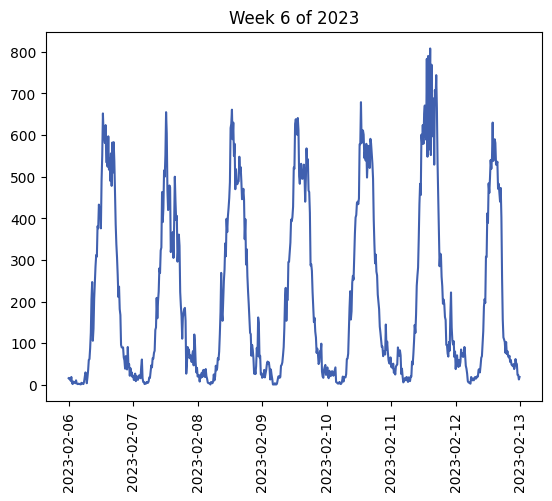

In [4]:
year = 2023

# Get unique week numbers in the data
unique_week_numbers = east_complete_days_df["date"].dt.isocalendar().week.unique()

# Loop through each week number
for week_number in unique_week_numbers:
    # Select data for the specific week and year
    ts_data = east_complete_days_df[
        (east_complete_days_df["date"].dt.isocalendar().week == week_number)
        & (east_complete_days_df["date"].dt.year == year)
    ]

    # Check if the length of the selected week matches the expected length
    is_complete = (4 * 24 * 7) == len(ts_data)

    # Print the week number if it is complete
    if is_complete:
        print(f"Week {week_number} is complete.")
        break

print(
    f"Week {week_number} data stored in `df_selected_week` with length {len(ts_data)}"
)

plt.plot(ts_data["value"])
plt.xticks(rotation=90)
plt.title(f"Week {week_number} of {year}")

timeseries = ts_data[["value"]].values.astype("float32")

## 3.2 Data Cleaning Report

* Detail the process of cleaning the data i.e. dealing missing values, duplicate records, or inconsistent entries.
* Discuss the methods used for cleaning (e.g., deletion, imputation, etc.) and a justification of choices.
* Highlight any challenges faced during the data cleaning process.
* Provide before and after summaries to demonstrate the effects of our cleaning efforts.

## 3.3 Derived Attributes / Records

* Discuss any new attributes or records that were derived from existing ones, such as creating new features through binning, combining attributes, or performing calculations.
* Explain why these transformations were done, and how these new attributes will contribute to the data mining goals.
* If applicable, describe any generation of synthetic data or aggregation of data at different levels.

We are going to add a number of new features that are derived from existing data. These are periods for the strongest signals calculated using the Lomb-Scargle Periodogram. The purpose of this is to give context to the model for the position of values in the time series. This is especially important as there are a large number of missing days now that all non-complete days have been removed. 

## 3.4 Merged Data

* Describe any data that was merged or joined together from different sources or tables.
* Discuss the methods used to combine the data and any difficulties faced (like inconsistencies or discrepancies between the datasets).
* Explain how any issues were resolved (e.g., how discrepancies were reconciled).
* Detail how the merged data was validated to ensure correctness.

We are going to add the term dates to the data for use in the model. This will be a boolean value. 

## 3.5 Reformatted Data

* Describe the process of reformatting the data for modeling or visualization purposes.
* Discuss any transformations of the data into different types (e.g., numerical to categorical, date-time conversions), creation of dummy variables, or re-scaling of features.
* Explain how and why any re-sampling procedures were done, if applicable.
* Discuss the format that the final dataset(s) will be in for the subsequent modeling or visualization stage.

## Model 0 - Baseline
This model takes the current value as input and returns it for the next time step, effectively predicting "no change". As our model can currently only predict a single time step into the future and the prediction will not change as window length increases. We can add an option to increase the number of predictions that the model makes however and see how performance changes as the number of time steps is increased. For single time-steps the baseline should be a reasonable estimate as the number of pedestrians generally changes slowly throughout the day. First we need to change our `pandas.core.series.Series` object into a `numpy.ndarray` object. We are dealing with a single dimensional array and the values form a time vector i.e. they are an ordered list. 

We then want to split the data into windows. In our first test run, we use a week of continuous data, and split it into windows of `WINDOWSIZE=1` and `HORIZON=1`. The baseline model will take the input and return that value as the output. We will then calculate some scores to see how far the predictions are from the labels. 

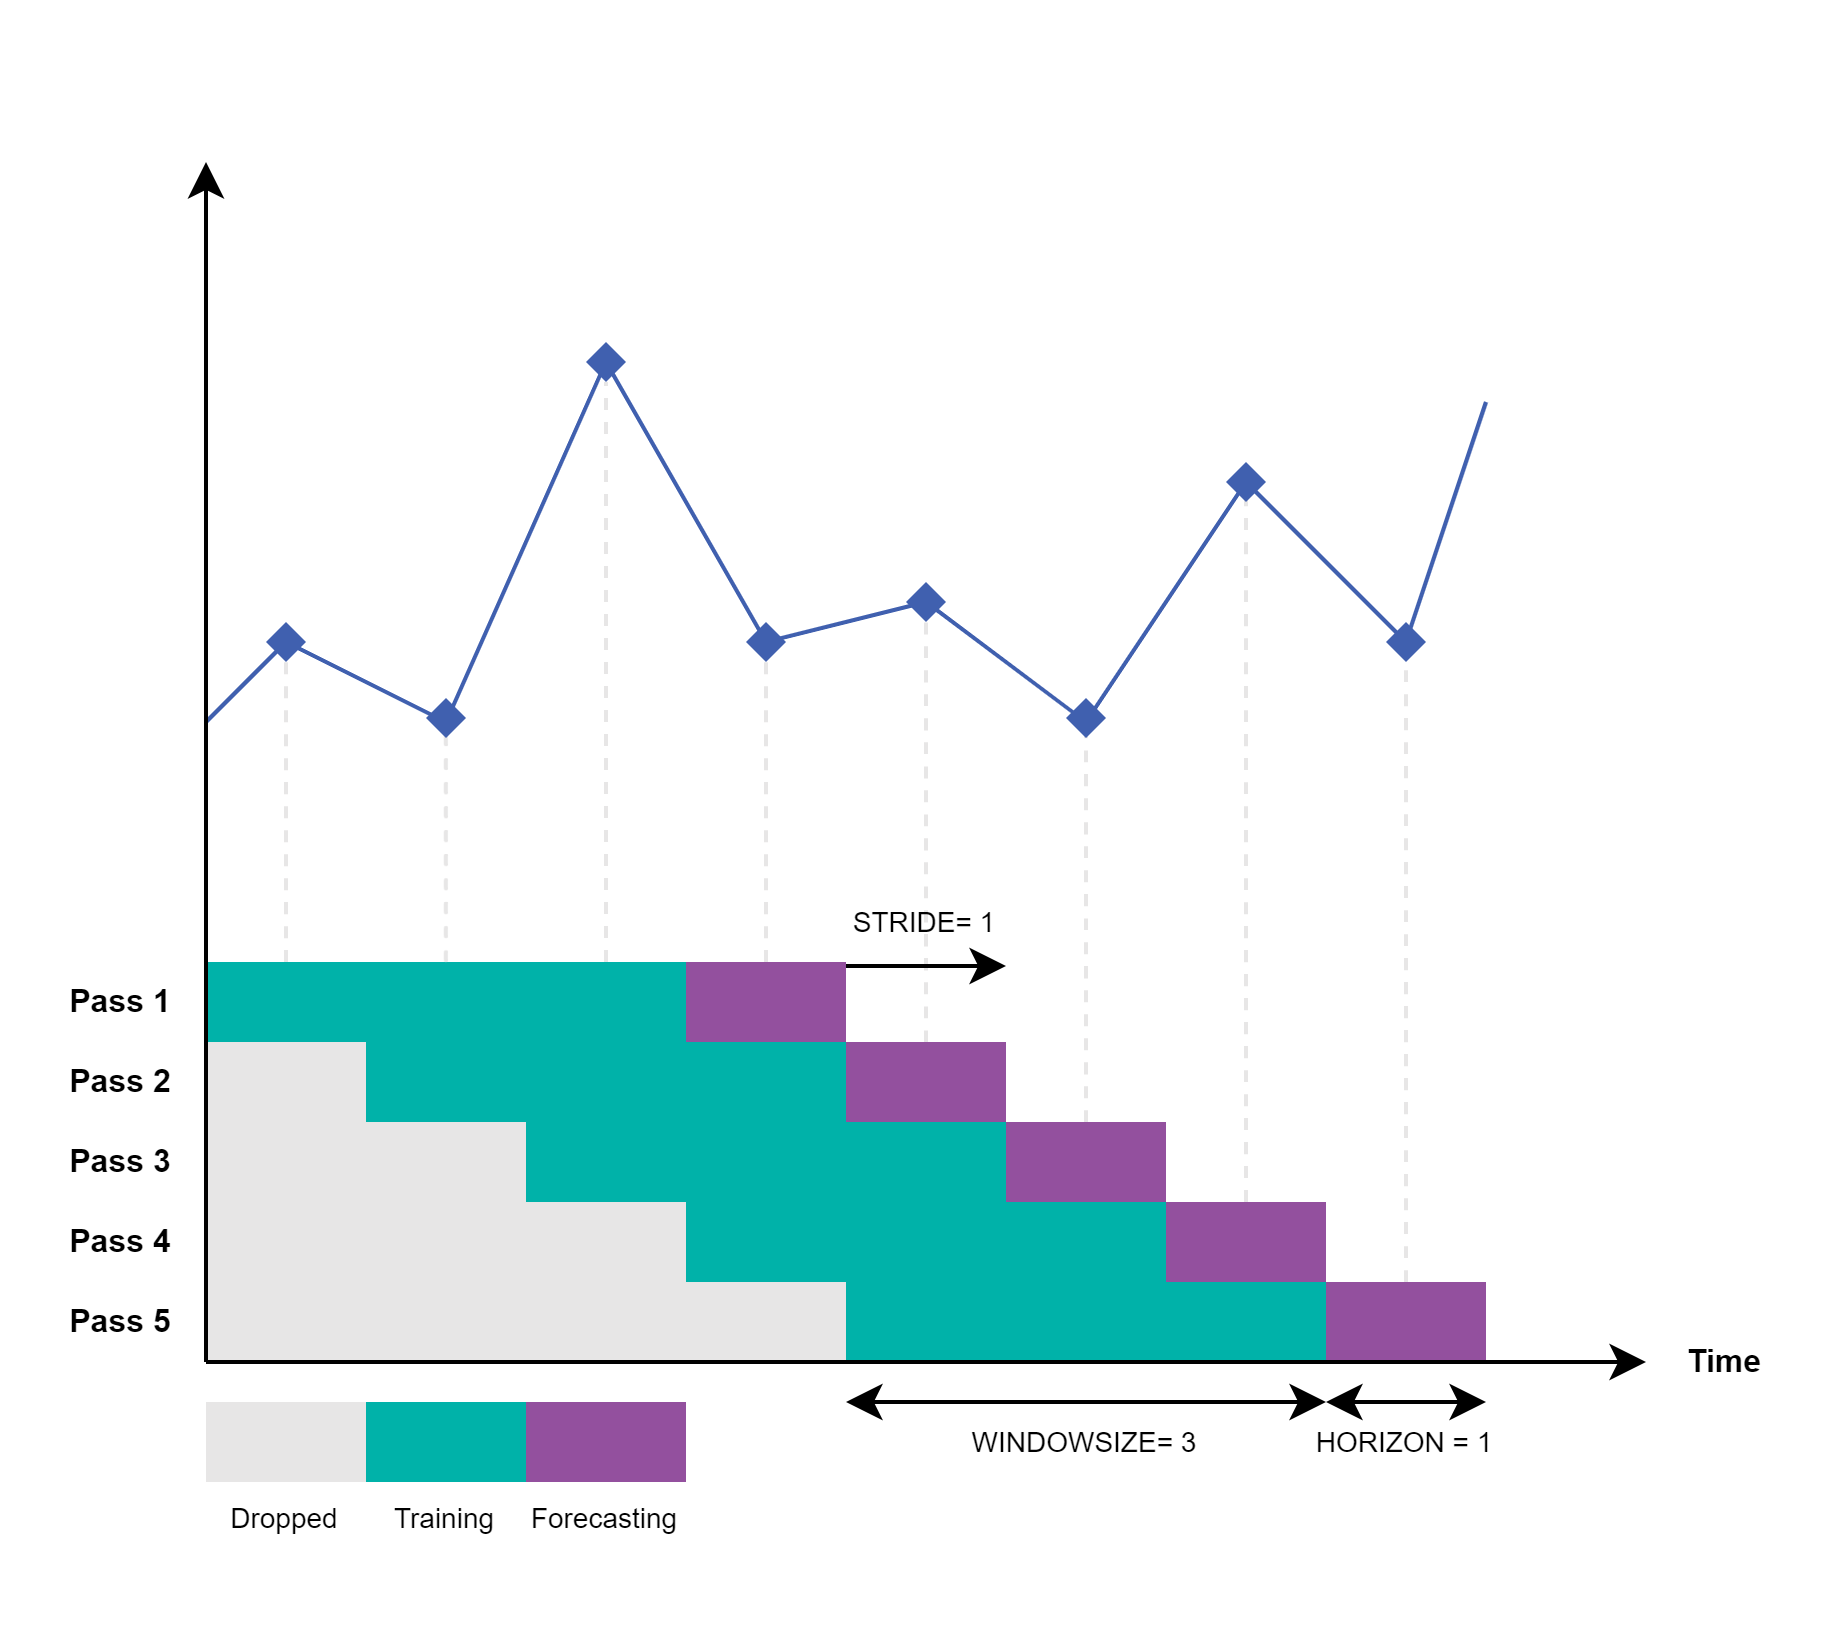

In [5]:
from IPython import display
import os

display.Image(
    os.path.join(os.getcwd(), "graphics\sliding_window_w3h3s1.png"),
    width=768,
    height=768,
)

Input shape: (10,) | Target shape: (4,)
Inputs array shape: (659, 10) | Target array shape: (659, 4)


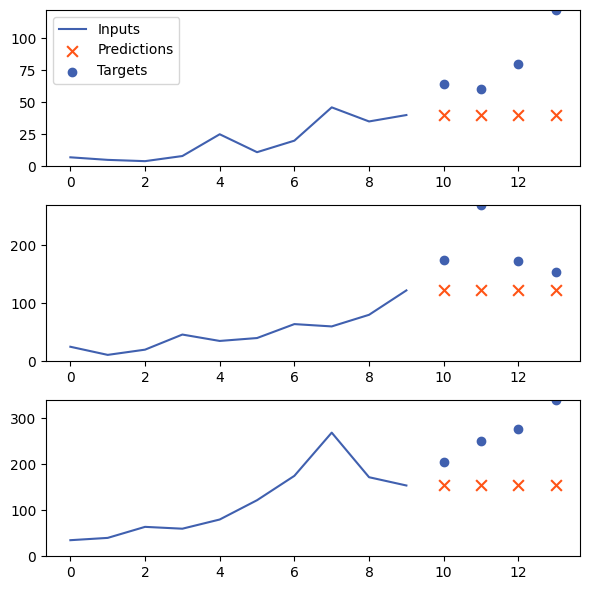

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.animation as animation
import IPython.display as ipy
from IPython.display import HTML
from eda_helper import sliding_windows_array, sliding_windows_tensor, plot_windows

X_train = torch.tensor(ts_data["value"].to_numpy(), dtype=torch.int32)[:384]
y_train = torch.tensor(ts_data["value"].to_numpy(), dtype=torch.int32)[:384]


WINDOW_SIZE = 10
HORIZON = 4
inputs_np, targets_np = sliding_windows_array(
    ts_data["value"].values, WINDOW_SIZE, HORIZON
)
print(f"Inputs array shape: {inputs_np.shape} | Target array shape: {targets_np.shape}")


class Model0(nn.Module):
    def __init__(self, horizon):
        super().__init__()
        self.horizon = horizon

    def forward(self, x):
        # Get the last element from each input sequence
        last_values = x[:, -1:]
        # Repeat this value to match the horizon length
        return last_values.expand(-1, self.horizon)


baseline = Model0(HORIZON)
inputs = torch.tensor(inputs_np, dtype=torch.float32)  # Ensuring inputs are float
predictions = (
    baseline(inputs).detach().numpy()
)  # Converting torch tensor to numpy array for plotting

plot_windows(inputs_np, predictions, targets_np, num_plots=3, step=4)

In [7]:
plt.ioff()  # Turn off interactive plotting

fig, ax = plt.subplots(1, 1, figsize=(6, 4))


def animate(i):
    ax.clear()
    ax.plot(
        range(len(inputs_np[i])),
        inputs_np[i],
        label="Inputs",
        color=custom_palette[0],
    )
    ax.scatter(
        range(len(inputs_np[i]), len(inputs_np[i]) + len(predictions[i])),
        predictions[i],
        label="Predictions",
        color=custom_palette[1],
        marker="x",
        s=60,
    )
    ax.scatter(
        range(len(inputs_np[i]), len(inputs_np[i]) + len(targets_np[i])),
        targets_np[i],
        label="Targets",
        color=custom_palette[0],
    )
    ax.legend()
    ax.set_title(f"Window {i+1}")
    ax.set_ylim(0, 1000)


# Assign the FuncAnimation to a variable
ani = animation.FuncAnimation(fig, animate, frames=len(inputs_np[:96]), repeat=True)

# Create a display object
display_obj = HTML(ani.to_jshtml())

# Display the object
ipy.display(display_obj)

plt.ion()  # Turn the interactive mode back on

### Model 0 Performance

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert targets to numpy array for calculation of metrics
targets = targets_np

# Flattening predictions and targets for metric calculations
predictions_flat = predictions.flatten()
targets_flat = targets.flatten()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(targets_flat, predictions_flat)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((targets_flat - predictions_flat) / targets_flat)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# R-squared (R²)
r2 = r2_score(targets_flat, predictions_flat)
print(f"R-squared (R²): {r2}")

# Create a dictionary with the metrics
metrics = {
    "Model": "Baseline",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R^2": r2,
}

performance_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "MAPE", "R^2"])
# Append the dictionary to the DataFrame
metrics_df = pd.DataFrame(metrics, index=[0])
performance_df = pd.concat([performance_df, metrics_df])

# Print the DataFrame
print(performance_df)

Mean Absolute Error (MAE): 47.21054628224583
Mean Squared Error (MSE): 4994.103566009105
Root Mean Squared Error (RMSE): 70.66897173448262
Mean Absolute Percentage Error (MAPE): 57.36360079248548%
R-squared (R²): 0.8918508352113226
      Model        MAE          MSE       RMSE       MAPE       R^2
0  Baseline  47.210546  4994.103566  70.668972  57.363601  0.891851


## Model 1: Simple LSTM

In [9]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

WINDOW_SIZE = 4
HORIZON = 1

X_train, y_train = sliding_windows_tensor(train, WINDOW_SIZE, HORIZON)
X_test, y_test = sliding_windows_tensor(test, WINDOW_SIZE, HORIZON)

Input shape: (4, 1) | Target shape: (1, 1)
Input shape: (4, 1) | Target shape: (1, 1)


c:\#code\#python\#current\mres-project\analysis_files\eda_helper.py:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(inputs), torch.tensor(targets)


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([446, 4, 1]) torch.Size([446, 1, 1])
torch.Size([218, 4, 1]) torch.Size([218, 1, 1])


In [11]:
class LSTMModel1(nn.Module):
    def __init__(self, *args, **kwargs) -> torch.Tensor:
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x[:, -1, :]  # Selecting the last output of the sequence

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

LSTM_v1 = LSTMModel1()
optimiser = optim.Adam(LSTM_v1.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train.squeeze(-1)), shuffle=True, batch_size=8
)

EPOCHS = 1000
for epoch in range(EPOCHS):
    LSTM_v1.train()
    for X_batch, y_batch in loader:
        # 1. Do the forward pass
        y_pred = LSTM_v1(X_batch)
        # 2. Calculate the loss
        loss = loss_fn(y_pred, y_batch)
        # 3. Zero the gradients
        optimiser.zero_grad()
        # 4. Perform backpropagation
        loss.backward()
        # 5. Gradient descent
        optimiser.step()
    if epoch % 100 != 0:
        continue
    LSTM_v1.eval()
    with torch.inference_mode():
        y_pred = LSTM_v1(X_train)
        # using sklearn to get more metrics?
        # train_mae = mean_absolute_error(y_pred, y_train)
        # train_mse = mean_squared_error(y_pred, y_train)
        # train_rmse = np.sqrt(mean_squared_error(y_pred, y_train))
        train_rmse = np.sqrt(loss_fn(y_pred, y_train.squeeze(-1)))
        test_pred = LSTM_v1(X_test)
        test_rmse = np.sqrt(loss_fn(test_pred, y_test.squeeze(-1)))
    print(f"Epoch: {epoch} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

Epoch: 0 | Train RMSE: 295.3399 | Test RMSE: 301.4867
Epoch: 100 | Train RMSE: 158.3620 | Test RMSE: 176.5921
Epoch: 200 | Train RMSE: 71.6077 | Test RMSE: 97.6240
Epoch: 300 | Train RMSE: 42.3782 | Test RMSE: 65.0232
Epoch: 400 | Train RMSE: 36.4718 | Test RMSE: 57.1967
Epoch: 500 | Train RMSE: 38.8451 | Test RMSE: 61.0261
Epoch: 600 | Train RMSE: 35.9771 | Test RMSE: 58.3500
Epoch: 700 | Train RMSE: 33.7724 | Test RMSE: 57.5299
Epoch: 800 | Train RMSE: 32.8332 | Test RMSE: 55.7609
Epoch: 900 | Train RMSE: 34.7267 | Test RMSE: 56.6306


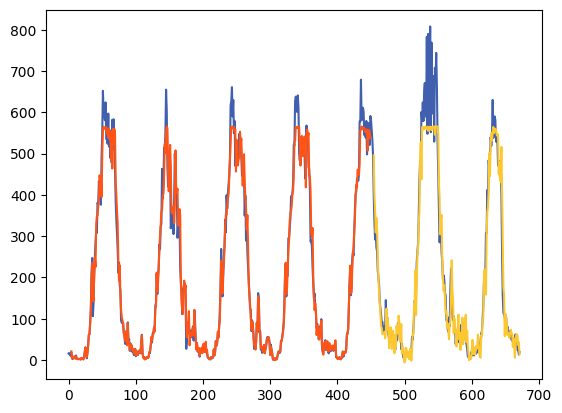

In [19]:
with torch.inference_mode():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = LSTM_v1(X_train)
    y_pred = y_pred[:, -1]
    train_plot[WINDOW_SIZE:train_size] = np.expand_dims(y_pred.detach().numpy(), axis=1)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_pred = LSTM_v1(X_test)[:, -1]
    test_plot[train_size + WINDOW_SIZE : len(timeseries)] = np.expand_dims(
        test_pred.detach().numpy(), axis=1
    )
# plot
plt.plot(timeseries, c=custom_palette[0])
plt.plot(train_plot, c=custom_palette[1])
plt.plot(test_plot, c=custom_palette[2])
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

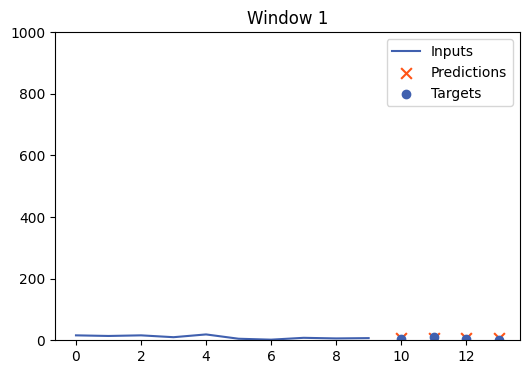

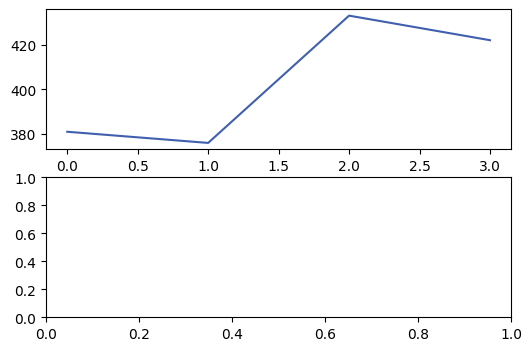

In [13]:
plot_windows(X_batch, y_pred, y_test, num_plots=2, step=1)

Windowing, also known as "rolling windows" or "sliding windows," is a common method used in time series analysis and is often used with machine learning models. However, whether it's essential or not depends largely on the specific task, data characteristics, and the model being used.

Here are some points to consider:

**Sequence Learning**: Many machine learning models, especially those used for time series like Recurrent Neural Networks (RNNs) and its variants (like LSTM and GRU), require input in the form of sequences. They make predictions based on the "memory" of past data points. Windowing is a way of creating these sequences from a time series.

**Stationarity**: Windowing can help make a time series more stationary (i.e., its properties do not depend on the time at which the series is observed) by creating a series of differences between values in the window, which is a requirement for certain models.

**Feature Engineering**: Windowing can also be used for feature engineering, where you create new features based on a window of values - such as rolling averages, standard deviations, etc. This can help capture trends and seasonality in the data which can be crucial for the performance of the models.

**Reduce Noise**: A windowed average can sometimes help reduce noise and smooth out short-term fluctuations, which may be beneficial for the model.

**Temporal Dependencies**: In time-series problems, current outputs can be dependent on previous inputs or outputs (auto-regressive nature). Windowing allows capturing these temporal dependencies.

However, it's worth noting that windowing is just one of many techniques in time series analysis. Depending on the nature of your problem, other techniques may also be applicable and useful. It is always recommended to understand your data and problem thoroughly and choose the techniques that are most appropriate for your specific use case.

Aside from windowing, there are various techniques used in time series analysis, including:

* Autoregression (AR): Models the next step in the sequence as a linear function of the observations at prior time steps.
* Moving Average (MA): Models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.
* Autoregressive Moving Average (ARMA): Models the next step in the sequence as a linear function of the observations and residual errors at prior time steps.
* Autoregressive Integrated Moving Average (ARIMA): An extension of ARMA that can model a wide range of time series data.
* Seasonal Autoregressive Integrated Moving-Average (SARIMA): An extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
* Vector Autoregression (VAR): Models the next step in each time series using an AR model.
* Vector Autoregression Moving-Average (VARMA): Models the next step in each time series using an ARMA model.
* Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX): An extension of the VARMA model that also includes the modeling of exogenous variables.
* Simple Exponential Smoothing (SES): Models the next time step as an exponentially weighted linear function of observations at prior time steps.
* Holt Winter’s Exponential Smoothing (HWES): Models the next step in the sequence as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.